In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import math

In [2]:
import thinfilm as tf
import tmm

In [19]:
from subprocess import call, Popen, PIPE, STDOUT

In [43]:
r = call(['g++', '-o', 'thinfilm', 'thinfilm.cc'])
assert r == 0

In [32]:
def c2b(x):
    r = x.real
    i = x.imag
    
    if i == 0:
        return bytes(str(r), 'utf-8')
    
    return b'(' + bytes(str(r), 'utf-8') + b',' + bytes(str(i), 'utf-8') + b')'

In [37]:
def plot(theta, x):
    plt.plot(theta, x[:,0], 'r-', theta, x[:,1], 'r--')
    plt.plot(theta, x[:,2], 'b-', theta, x[:,3], 'b--')
    plt.legend(['reflectanceP', 'reflectanceS', 'transmittanceP', 'transmittanceS'])

def foo_tf(theta, nin, nex, layers):
    x = np.zeros((len(theta), 4))

    for i, th in enumerate(theta):
        x[i] = tf.compute(np.cos(th), nin, nex, layers)

    return x

def foo_cpp(theta, nin, nex, layers):
    x = np.zeros((len(theta), 4))

    for i, th in enumerate(theta):
        x[i] = tf.compute(np.cos(th), nin, nex, layers)
        p = Popen(['./thinfilm'], stdout=PIPE, stdin=PIPE, stderr=PIPE)
        xs = [np.cos(th), nin, nex, len(layers)]
        xs += [x for layer in layers for x in layer]
        msg = b' '.join([c2b(x) for x in xs])
        stdout_data = p.communicate(input=msg)[0]

        [float(x) for x in stdout_data.split()]

    return x

def foo_tmm(theta, nin, nex, layers):
    d_list = [tmm.inf] + [l[1] for l in layers] + [tmm.inf]
    # list of refractive indices
    n_list = [nin] + [l[0] for l in layers] + [nex]

    x = np.zeros((len(theta), 4))

    for i, th in enumerate(theta):
        resP = tmm.coh_tmm('p', n_list, d_list, theta[i], 1)
        resS = tmm.coh_tmm('s', n_list, d_list, theta[i], 1)
        x[i] = [resP['R'], resS['R'], resP['T'], resS['T']]
    
    return x
    
def compare(nin, nex, layers):
    theta = np.linspace(0, 0.5 * np.pi, 200)
    
    x = foo_cpp(theta, nin, nex, layers)
    x_tmm = foo_tmm(theta, nin, nex, layers)
    
    plot(theta, x)
    plt.figure()
    plot(theta, x_tmm)
    
    plt.figure()
    plot(theta, x - x_tmm)

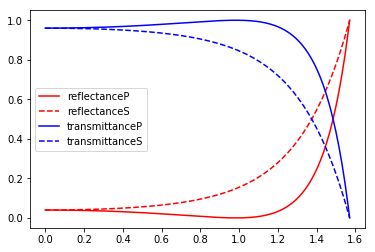

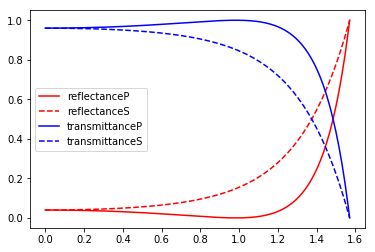

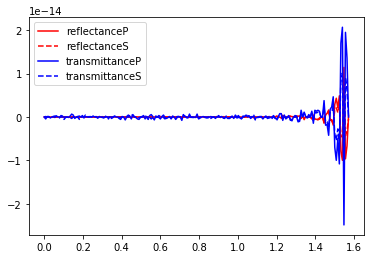

In [38]:
compare(1.0, 1.5, [])

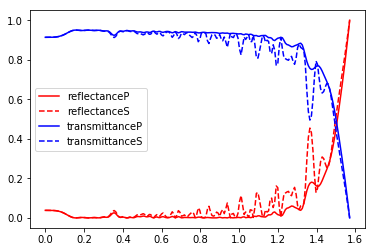

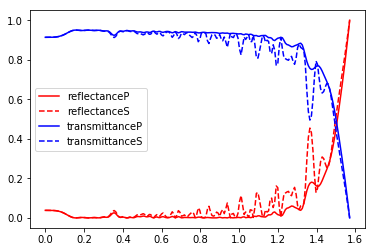

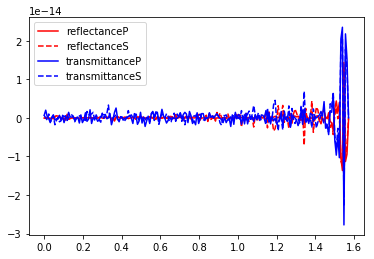

In [39]:
compare(1.0, 1.5, [[1.1+1e-4j, 10], [1.2+1e-4j, 10], [1.3+1e-4j, 10], [1.4+1e-4j, 10]])

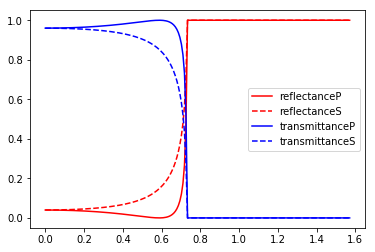

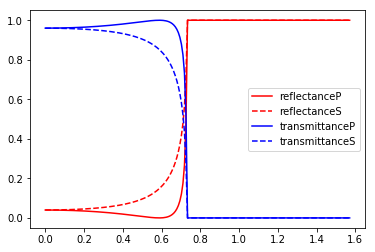

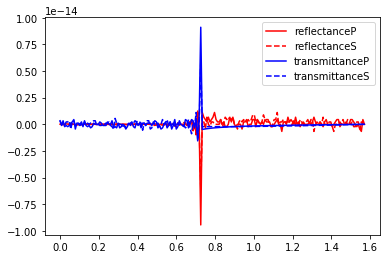

In [40]:
compare(1.5, 1.0, [])

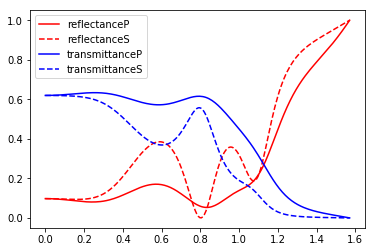

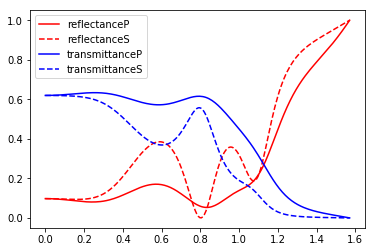

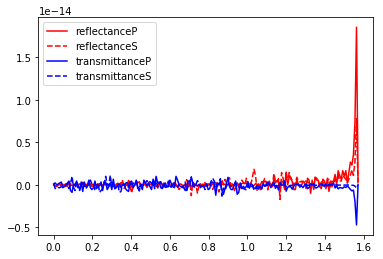

In [41]:
compare(1.5, 1.0+1j, [[2+0.01j, 1], [1.4+0.02j, 0.5]])